# Cross validation

In some previous exercises, we verified the results obtained with our point estimation methods (Kriging included) by comparing the results against some reference data and agains the a reference "truth". In real case studies, a reference "truth" is not avaiable. Nevetheless, when many data are available, one can keep a portion of the data aside and use them only to validate the procedure.

The *cross validation* technique, or "leave one out" techniche, is based on this principle:

1. remove one point were we have a measurement;
3. use Kriging to estimate ad that point;
4. compute the error done by the estimation in that point;
5. repeat the procedure for all the available measurement point;
6. compute a Mean Absolute Error, MSE or RMSE.

Hereinafter an example application with some syntetic data, inspided from the script [ex_vario_analysis_data1D_1.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_vario_analysis_data1D_1.ipynb) of the library [geone](https://github.com/randlab/geone) by Julien Straubhaar.

First of all, import the required modules.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import time

# import package 'geone'
import geone as gn

Then, read the input data and plot them.

Text(0, 0.5, 'v')

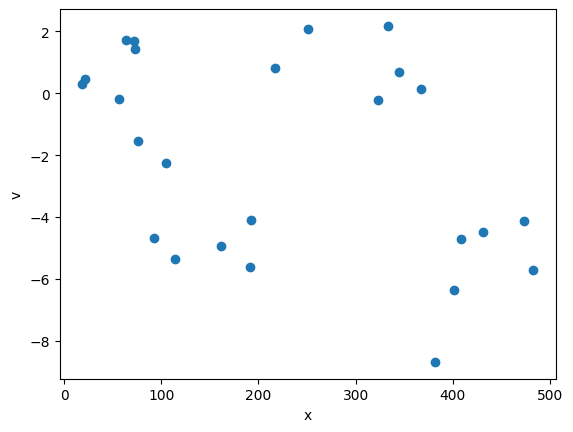

In [2]:
x, v = np.loadtxt("samples.txt", unpack=True)

fig, ax = pl.subplots(1,1)
ax.scatter(x,v)
ax.set_xlabel("x")
ax.set_ylabel("v")


Our aim is to perform some point estimation with Kriging, and then evaluate the quality of our results with cross validation. Therefore, we need first to plot an experimental variogram.  
This can be done, in the library `geone`, with the function `covModel.variogramExp1D`. Let's try first with the default parameters.

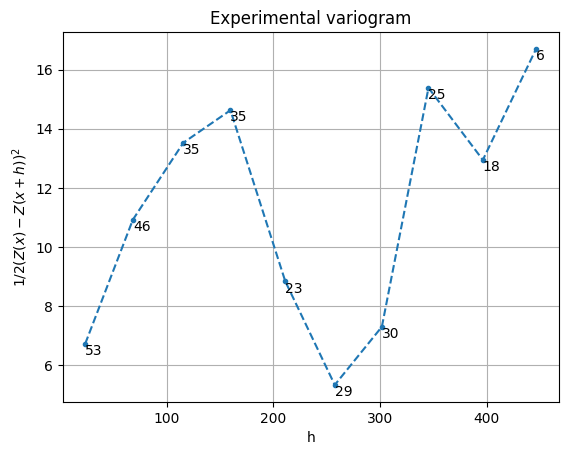

In [3]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v)

We can also try by manually defining some parameters, like for example the number of bins or "classes" and the maximim value of $h$ to be explored

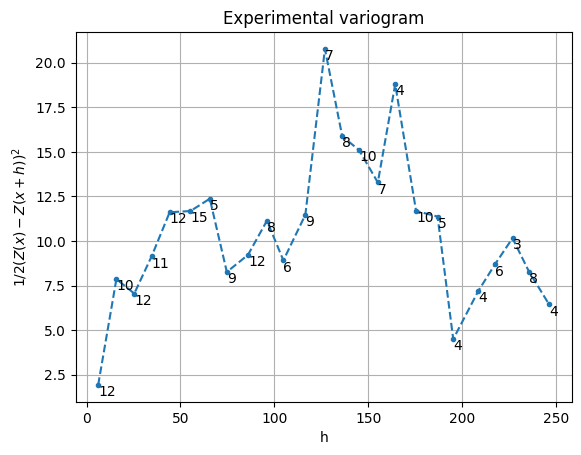

In [4]:
hexp, gexp, cexp = gn.covModel.variogramExp1D(x, v, hmax=250, ncla=25)

We can now fit our variogram with some model. For doing this with the library `geone` we use `covModel.CovModel1D_fit`.

To start with, we define a variogram model made of the combination of four models, Gaussian, spherical, exponential and nugget. For the moment, we leave the values of the weight of each contribution (`w`) and the range (`r`, clearly non available for nugget)

In [5]:
cov_model_to_optimize = gn.covModel.CovModel1D(
    elem=[('gaussian',    {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':np.nan}), # elementary contribution
          ('nugget',      {'w':np.nan})              # elementary contribution
                ], name='')

The function `gn.covModel.covModel1D_fit` is based on some `scipy` optimization techniques. Sometimes, if the number of contraints on the parameters to be estimated is not sufficient, optimal values of the parameters `w` and `r` for the various contributions cannot be computed (try to run the following cell...).

/home/alex/.virtualenvs/gmg/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


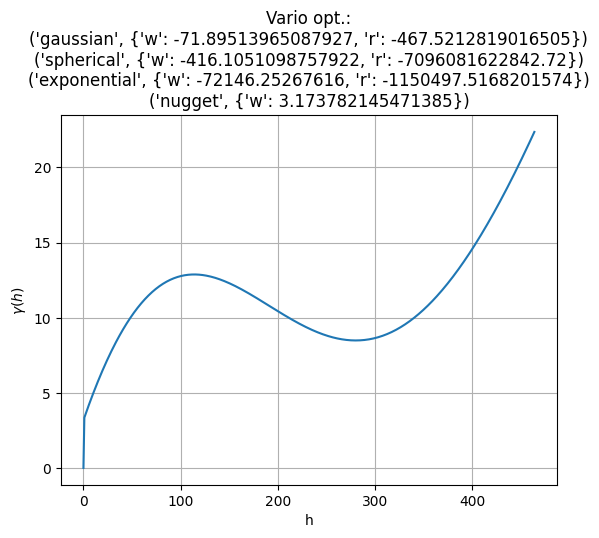

In [6]:
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize)

We therefore need to add some contraints on the values of the parameters `w` and `r`. These contraints can be guessed from the experimental variogram.  

First of all, the parameter `w`, which is somehow related to the variance, coud be bounded by observing that the experimental variogram is almost always below 20. Therefore, we can impose that `w` should be in the interval $[0,20]$.

Another parameter that can be extracted from the experimental variogram is the range. It seems that the variogram reaches somehow some sill after about 150 unit lenghts. To be cautious, we can impose that `r` should be in the interval $[0,300]$.

In practice, this can be written in Python like this:

In [7]:
cov_model_opt, popt = gn.covModel.covModel1D_fit(x, v, cov_model_to_optimize,# hmax=300,
                                                 bounds=([ 0,   0,  0,   0,  0,   0,  0], 
                                                         [20, 300, 20, 300, 20, 300, 20]),
                                                 make_plot=False)

The variable `popt` contains the values of the optimized parameters `w` and `r` for the four models. You can check its content if you want.

We can then plot the computed "optimal" model and the experimental variogram

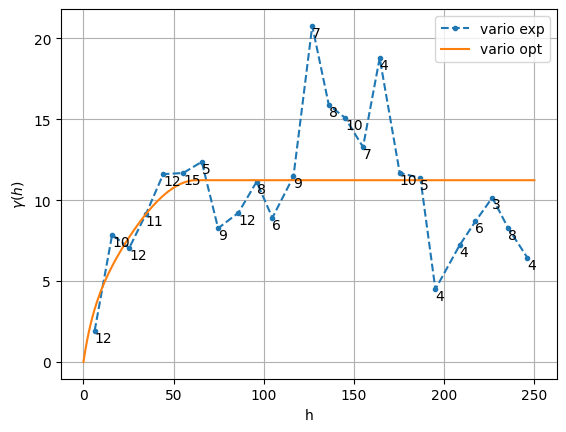

In [8]:
gn.covModel.plot_variogramExp1D(hexp, gexp, cexp, label='vario exp')
cov_model_opt.plot_model(vario=True, hmax=250, label='vario opt')
pl.legend()


Once we have a variogram model (and once defined a grid where to estimate our values), we can apply Kriging, for example ordinary Kriging.

## Cross validation (with ordinary Kriging)

We can apply *cross validation* (or *leave one out* method, `loo`) to check the perfomances of the selected interpolation method, or the evaluate the choice of the variogram model.

This is done with the function `cross_valid_loo`, that with the argument `make_plot=True` can be also used to directly plot the results.

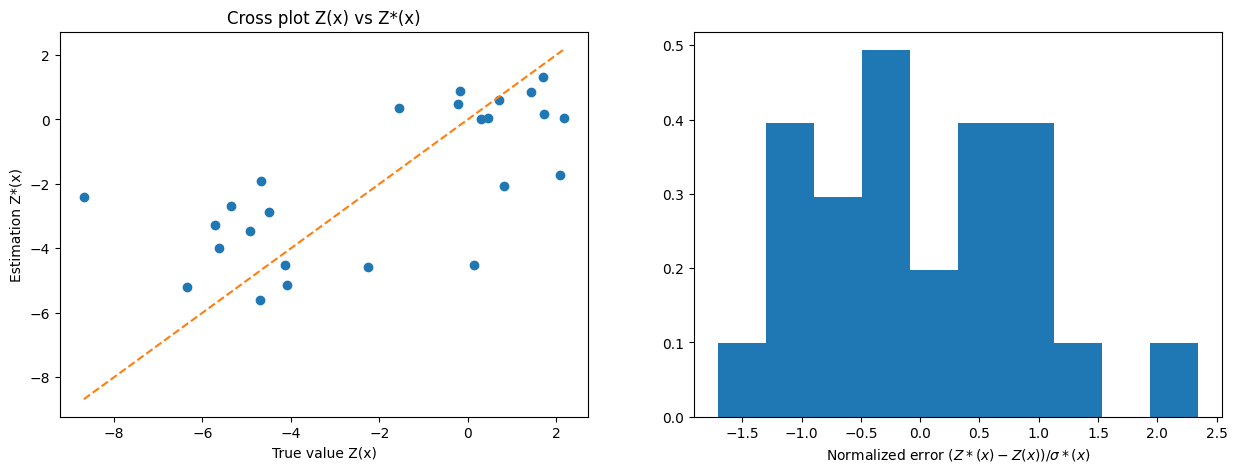

In [9]:
# Interpolation by ordinary kriging
cv_est, cv_std, test_normal, test_chi2 = gn.covModel.cross_valid_loo(x, v, cov_model_opt,
                                                interpolator_kwargs={'method':'ordinary_kriging'},
                                                make_plot=True, figsize=(15,5))

The function `cross_valid_loo` returns four values:

1. The estimated values at the "left out" locations
2. The variance at the "left out" locations
3. A boolean value to check if some test about the normality of the mean normalized error.
4. The result of a Chi squared test.

You can check all these return values if you want.

Here we will focus on the first return value and look for a numerical value to quantify the goodness of our interpolation method by computing the RMSE on the estimated value errors.

In [10]:
cv_RMSE = np.sqrt(np.sum((v-cv_est)**2)/len(v))
print("Cross validation RMSE (ordinary Kriging): {0:.2f}".format(cv_RMSE))

Cross validation RMSE (ordinary Kriging): 2.32


## Cross validation for comparing different estimation methods

The cross correlation provides a quantitative way to evaluate the quality of our estimation procedure. We can for example perform a cross validation of a different Kriging flavour, for example *simple Kriging* (simple Kriging is the simplest formulation of Kriging, but it assumes that the expectation value is known everywhere; in practice this is never the case).

Using the same approach considered above, with the same variogram but with a different Kriging paradigm (simple kriging in the place of ordinary Kriging) we can run again the cross validation:

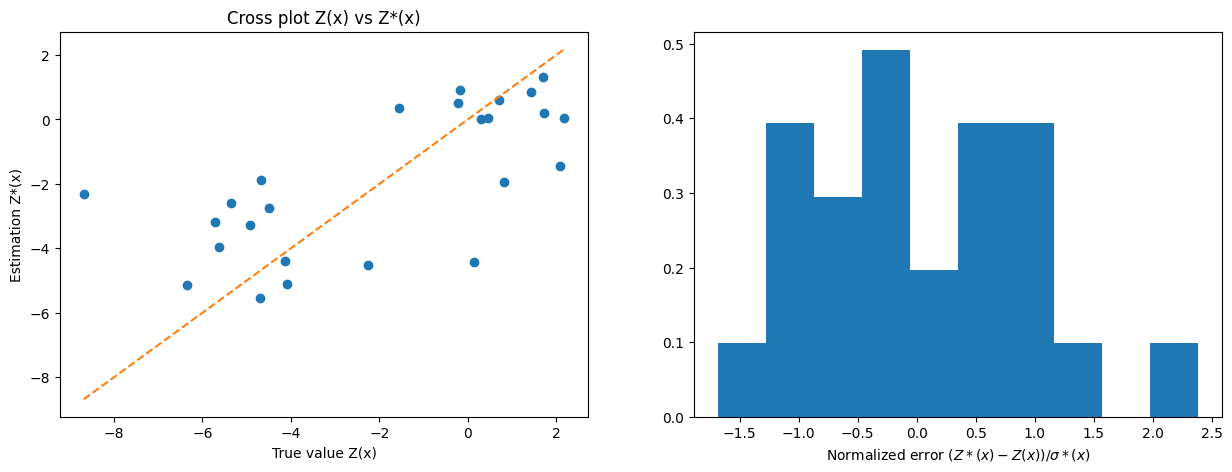

In [11]:
# Interpolation by simple Kriging
cv_est_sk, cv_std_sk, test_normal_sk, test_chi2_sk = gn.covModel.cross_valid_loo(x, v, cov_model_opt,
                                                interpolator_kwargs={'method':'simple_kriging'},
                                                make_plot=True, figsize=(15,5))

In [12]:
cv_RMSE_sk = np.sqrt(np.sum((v-cv_est_sk)**2)/len(v))
print("Cross validation RMSE (simple Kriging): {0:.2f}".format(cv_RMSE_sk))

Cross validation RMSE (simple Kriging): 2.31


In this case, using the same variogram, simple Kriging , with a cross validation RMSE of 2.31, perform sligtly better than ordinary Kriging (2.32).

We can also keep the same Kriging flavour and check which variogram model provides better estimates in terms of cross validation RMSE.

## Check with the "true" variogram model



The variogram used to generate the syntetic data set used in this notebook (see the file ``00_create_data.npynb`` for more details) is a mixture of three models, one spherical with weight 7 and range 100, and one exponential with a weight of 2.5 and range 50, with a nugget effect of 0.5.

In terms of `geone` variogram model (covariance function) this corresponds to

In [14]:
cov_model_ref = gn.covModel.CovModel1D(elem=[
    ('spherical', {'w':7., 'r':100}),   # elementary contribution
    ('exponential', {'w':2.5, 'r':50}), # elementary contribution
    ('nugget', {'w':0.5})               # elementary contribution
    ], name='ref model')


With this variogram, we can apply again cross validation with ordinary Kriging

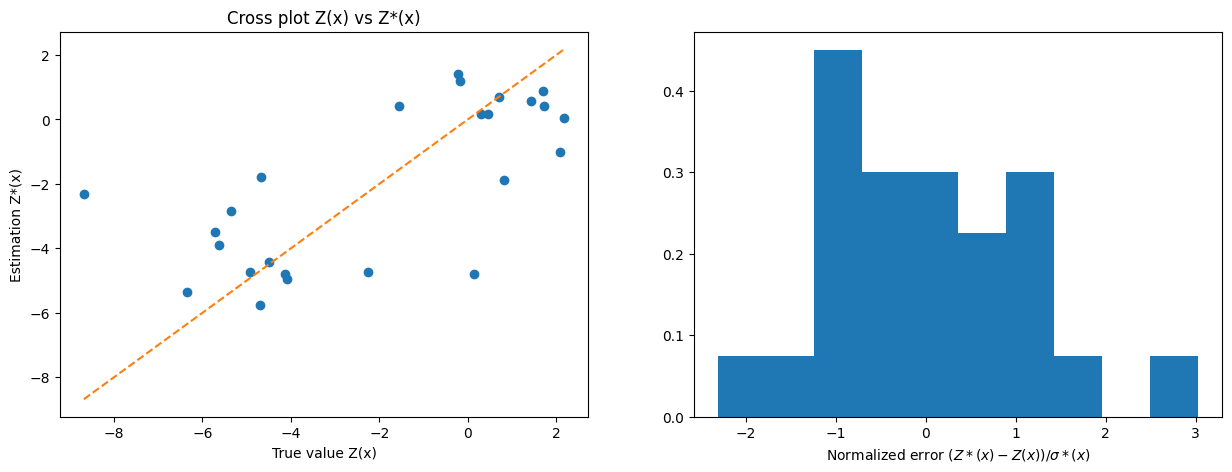

In [15]:
# Interpolation by ordinary kriging
cv_est_ref, cv_std_ref, test_normal, test_chi2 = gn.covModel.cross_valid_loo(x, v, cov_model_ref,
                                                interpolator_kwargs={'method':'ordinary_kriging'},
                                                make_plot=True, figsize=(15,5))

And again compute a RMSE on this "reference" results, obtained with the original variogram.

In [16]:
cv_RMSE_ref = np.sqrt(np.sum((v-cv_est_ref)**2)/len(v))
print("Cross validation RMSE (simple Kriging): {0:.2f}".format(cv_RMSE_ref))

Cross validation RMSE (simple Kriging): 2.28


In this case, by using the same variogram used to create the syntetic data set, we have sliglty better results if compared with the results obtained with the fitted variogram model.